<a href="https://colab.research.google.com/github/night2wolf/CS490/blob/master/Assignment2/Membership_Attack_Whitebox_TKLINKENBERG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# required imports
import sys 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  


import torch
import torchvision 
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
# mount the google drive to download the datasets
from google.colab import drive
drive.mount('/content/drive')
project_path = '/CS490/ICP9'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# create transforms to load the images, nothing much is needed here. 
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])


In [0]:
# download CIFAR 10 training set
trainset = torchvision.datasets.CIFAR10(root= project_path+'/data', train=True, download=True, transform=transform)

# load the trainning set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# download the test data
testset = torchvision.datasets.CIFAR10(root= project_path+'/data', train=False, download=True, transform=transform)

# load the test data
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# check those manually on the dataset site: https://www.cs.toronto.edu/~kriz/cifar.html 

Files already downloaded and verified
Files already downloaded and verified


 ship  deer  frog plane


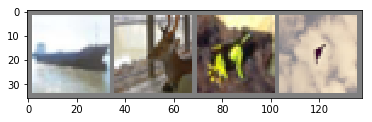

In [0]:
# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(imgs)) 

# notice who we converted the class idx to labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# run this cell multiple times and notice diff images

In [0]:
# divide the training dataset into the required groups Make sure they are balanced
# original trainset is made of 50k images

total_size = len(trainset)
split1 = total_size // 4
split2 = split1 * 2
split3 = split1 * 3

print(total_size, split1, split2, split3)

indices = list(range(total_size))

# two groups to train the shadow (in and out)
shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]

# two groups to train the Target (in and out)
target_train_idx = indices[split2:split3]
target_out_idx = indices[split3:]

50000 12500 25000 37500


In [0]:
batch_size = 64 # pick your own

# divide and load shadow train in and out
shadow_train_sampler = SubsetRandomSampler(shadow_train_idx) # Pytorch function
shadow_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_train_sampler)

shadow_out_sampler = SubsetRandomSampler(shadow_out_idx)
shadow_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_out_sampler)

# divide and load Target in and out
target_train_sampler = SubsetRandomSampler(target_train_idx)
target_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_train_sampler)

target_out_sampler = SubsetRandomSampler(target_out_idx)
target_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_out_sampler)


In [0]:
# create a CNN
# Input shape (3, 32, 32) 
# architecture: simple. 2 conv and 2 Max pool, followed by 2 fc (120, 84) 
# output of fc is 10 because we have 10 classes!

#Create Models

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
      
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      

      


In [0]:
class Attack_Model(nn.Module):
    def __init__(self):
        super(Attack_Model,self).__init__()
        self.fc1 = nn.Linear(10, 32)
        self.fc2 = nn.Linear(32,1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        return x

In [0]:
class Shadow_Model(nn.Module):
    def __init__(self):
        super(Shadow_Model, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
      
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,36)
        self.fc4 = nn.Linear(36,10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
      

In [0]:
# initalize a target model and train it
def train(model,criterion,epochs,training_set,learning_rate):
    optimizer = optim.Adam(model.parameters(), lr = learning_rate) 
    e = epochs
    losses = []
    for epoch in range(e):  
        model.train()
        
    
        for i, data in enumerate(training_set, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize  
        
        
            # make a prediction: forward prop
        
            # calculate the loss
            outputs = model(inputs)
            loss = criterion(outputs,labels)        
            # calculate gradients
            loss.backward()
            # updaate weights in backprop

            optimizer.step()
            # print statistics
            losses.append(loss.item())
            

    print('Finished Training the model...')

In [0]:
def train_attacker(attack_model,shadow_model,shadow_in,shadow_out,criterion,epochs,learning_rate,k):
    attack_m = attack_model
    shadow_m = shadow_model
    # Freeze Shadow Model for evaluation
    shadow_m.eval()
    criterion = criterion
    optimizer = optim.Adam(attack_m.parameters(), lr = learning_rate)
    e = epochs
    # Initialize predictions as empty arrays
    in_predicts = []
    out_predicts = []
    losses = []                
    attack_data_in = np.empty((0,2))
    attack_data_out = np.empty((0,2))
    for e in range(epochs):
    # Enumerate shadow data and merge it
        for i, ((in_data,_),(out_data,_)) in enumerate(zip(shadow_in,shadow_out)):
            #Flatten data and get the model probabilities
            label_tensor = in_data.shape[0]
            inputs = in_data.view(in_data.shape[0],-1)
            outputs = out_data.view(out_data.shape[0],-1)
            #in_data = shadow_m.predict_proba(inputs)
            #out_data = shadow_m.predict_proba(outputs)
            in_predictions = F.softmax(shadow_m(in_data.detach()), dim=1)
            out_predictions = F.softmax(shadow_m(out_data.detach()), dim=1)
            in_sort, _ = torch.sort(in_predictions, descending = True)
            in_sort_k = in_sort[:,:k].clone()
            # Create labels for prediction data
            in_lbl = torch.ones(label_tensor)
            out_lbl = torch.zeros(label_tensor)
            for data in in_sort_k:
                in_predicts.append((data.max()).item())
        
            out_sort, _ = torch.sort(out_predictions, descending = True)
            out_sort_k = out_sort[:,:k].clone()
            for data in out_sort_k:
                out_predicts.append((data.max()).item())

    
            running_loss = 0.0
            optimizer.zero_grad()
            in_p = torch.squeeze(attack_model(in_sort_k))
            out_p = torch.squeeze(attack_model(out_sort_k))
            loss_train = criterion(in_p,in_lbl)
            loss_out = criterion(out_p,out_lbl)
            loss = (loss_train + loss_out) / 2
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    print('Finished Training Attack Model.')
            

In [0]:
def eval_model(model,load_data):
  # calculate the accuracy of the Target Model
    correct = 0
    total = 0
    test_model = model
    with torch.no_grad():
        for data in load_data:
            images, labels = data
            outputs = test_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images in target out: %d %%' % (100 * correct / total))

In [0]:
def eval_attack_net(attack_net, target, target_train, target_out, k):
    # https://github.com/Lab41/cyphercat/blob/master/Utils/metrics.py
    
    in_predicts=[]
    out_predicts=[]
    losses = []
    target_net = target
    target_net.eval()
    attack_net.eval()

    
    precisions = []
    recalls = []
    accuracies = []

    #for threshold in np.arange(0.5, 1, 0.005):
    thresholds = np.arange(0.5, 1, 0.005)

    total = np.zeros(len(thresholds))
    correct = np.zeros(len(thresholds))

    true_positives = np.zeros(len(thresholds))
    false_positives = np.zeros(len(thresholds))
    false_negatives = np.zeros(len(thresholds))   
 
    train_top = np.empty((0,2))
    out_top = np.empty((0,2))
    
    for i, ((train_imgs, _), (out_imgs, _)) in enumerate(zip(target_train, target_out)):


        mini_batch_size = train_imgs.shape[0]
        train_imgs, out_imgs = train_imgs, out_imgs
        
        #[mini_batch_size x num_classes] tensors, (0,1) probabilities for each class for each sample)
        train_posteriors = F.softmax(target_net(train_imgs.detach()), dim=1)
        out_posteriors = F.softmax(target_net(out_imgs.detach()), dim=1)
        

        #[k x mini_batch_size] tensors, (0,1) probabilities for top k probable classes
        train_sort, _ = torch.sort(train_posteriors, descending=True)
        train_top_k = train_sort[:,:k].clone()
        out_sort, _ = torch.sort(out_posteriors, descending=True)
        out_top_k = out_sort[:,:k].clone()
        
        #Collects probabilities for predicted class.
        for p in train_top_k:
            in_predicts.append((p.max()).item())
        for p in out_top_k:
            out_predicts.append((p.max()).item())
        #print("train_top_k = ",train_top_k)
        #print("out_top_k = ",out_top_k)
        
        #print(train_top.shape)
        
        train_lbl = torch.ones(mini_batch_size)
        out_lbl = torch.zeros(mini_batch_size)
        
        #Takes in probabilities for top k most likely classes, outputs ~1 (in training set) or ~0 (out of training set)
        train_predictions = F.sigmoid(torch.squeeze(attack_net(train_top_k)))
        out_predictions = F.sigmoid(torch.squeeze(attack_net(out_top_k)))


        for j, t in enumerate(thresholds):
            true_positives[j] += (train_predictions >= t).sum().item()
            false_positives[j] += (out_predictions >= t).sum().item()
            false_negatives[j] += (train_predictions < t).sum().item()
            #print(train_top >= threshold)


            #print((train_top >= threshold).sum().item(),',',(out_top >= threshold).sum().item())

            correct[j] += (train_predictions >= t).sum().item()
            correct[j] += (out_predictions < t).sum().item()
            total[j] += train_predictions.size(0) + out_predictions.size(0)

    #print(true_positives,',',false_positives,',',false_negatives)

    for j, t in enumerate(thresholds):
        accuracy = 100 * correct[j] / total[j]
        precision = true_positives[j] / (true_positives[j] + false_positives[j]) if true_positives[j] + false_positives[j] != 0 else 0
        recall = true_positives[j] / (true_positives[j] + false_negatives[j]) if true_positives[j] + false_negatives[j] !=0 else 0
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)

    print("threshold = %.4f, accuracy = %.2f, precision = %.2f, recall = %.2f" % (t, accuracy, precision, recall))
        

        
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()
 

In [0]:
#Train the regular model
model = Net()
criterion = nn.CrossEntropyLoss()
train_data = target_train_loader
epochs = 25
lr = .001
train(model,criterion,epochs,train_data,lr)
eval_model(model,target_out_loader)

Finished Training the model...
Accuracy of the network on the 10000 test images in target out: 52 %


In [0]:
#Train the shadow model

shadow_model = Net()
shadow_criterion = nn.CrossEntropyLoss()
shadow_train_data = shadow_train_loader
shadow_epochs = 25
shadow_lr = .001
train(shadow_model,shadow_criterion,shadow_epochs,shadow_train_data,shadow_lr)
eval_model(shadow_model,shadow_out_loader)


Finished Training the model...
Accuracy of the network on the 10000 test images in target out: 53 %


Finished Training Attack Model.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


threshold = 0.9950, accuracy = 50.00, precision = 0.00, recall = 0.00


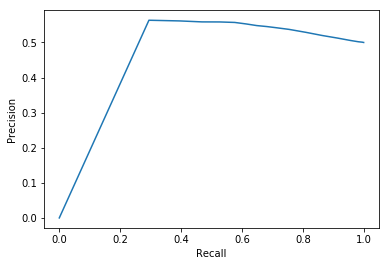

In [0]:
#Train the attack model
attack_model = Attack_Model()
shadow_model = shadow_model
attack_criterion = nn.MSELoss()
shadow_in = shadow_train_loader
shadow_out = shadow_out_loader
attack_epochs = 25
attack_lr = .001
k =10
train_attacker(attack_model,shadow_model,shadow_in,shadow_out,attack_criterion,attack_epochs,attack_lr,k)
eval_attack_net(attack_model,model,train_data,target_out_loader,k)



---



In [0]:

# initalize a Shadow Model and Train it
# for the first ICP, your shadow model can have the same CNN architecture and hyperparameters

In [0]:
# create the Attack Model: A NN binary classifier {0, 1}
# the input to this model is the propability distribution vector of size 10
# and the output is either 0 (input was not included in training) or 1

In [0]:
# calculate the recall and precision of your attack network using the Target_out and Target_in datasets
# to do so, take a random numer of datapoints, run them throw the target model,
# and then input the output of the target model to your attack network 
# you already know the target_in and target_out samples, so use that info to evaluate the attack model 


Great! At this point, you must have created a succesfful attack model that can detect whether a datapoint was used in training a target mode or not. 
* A successful attack model is one with a precision/recall higher than 85% -- you are using same architecture and are aware of the data classes

 
 Can you suggest any defense mechanism? If yes, Apply them to your solution and re-evaluate your attack model. How did your defense mecanism affect the accuracy of the target model? How did it affect the recall and precision of the Attack model?